## 9.4. 锚框

In [1]:
import d2lzh as d2l
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
np.set_printoptions(2)

/usr/local/anaconda3/envs/rknn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/anaconda3/envs/rknn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/anaconda3/envs/rknn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/anaconda3/envs/rknn/lib/python3.6/site-packages

### 9.4.1. 生成多个锚框
（例：以每个像素为中心生成多个大小和宽高比（aspect ratio）不同的边界框）
* 注意 Keras Tf Backend 是 NHWC，和MXNet是相反的

In [2]:
# return:  (b, an, 4) 4-> (x1/w, y1/h, x2/w, y2/h) 
def MultiBoxPrior(X, sizes, ratios, do_reduce=True):
    Y = []
    def foreach_radio_sizes(x, y, h, w, p):
        flag_first_size = True
        for ratio in ratios:
            flag_pass = False
            for size in sizes:
                if flag_pass:
                    continue
                if not flag_first_size and do_reduce:
                    flag_pass = True
                tw = w * size * np.sqrt(ratio)
                th = h * size / np.sqrt(ratio)
                
                x1 = (x - tw / 2) / w
                y1 = (y - th / 2) / h
                x2 = (x + tw / 2) / w
                y2 = (y + th / 2) / h
                p.append((x1, y1, x2, y2))
                
                #print(x1, y1, x2, y2, ratio, size)
            flag_first_size = False
        return p
    
    for b in X:
        batch = []
        h, w = b.shape[0:2]
        for y in range(h):
            for x in range(w):
                foreach_radio_sizes(x, y, h, w, batch)   
        Y.append(batch)
    
    return np.array(Y)

In [3]:
img = plt.imread('../img/catdog.jpg')
h, w = img.shape[0:2]

print(h, w)
X = np.random.uniform(size=(1, h, w, 3))  # 构造输入数据
Y = MultiBoxPrior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape

561 728


(1, 2042040, 4)

In [4]:
boxes = Y.reshape((h, w, 5, 4))
boxes[250, 250, :, :]

array([[-0.03,  0.07,  0.72,  0.82],
       [ 0.09,  0.2 ,  0.59,  0.7 ],
       [ 0.22,  0.32,  0.47,  0.57],
       [-0.19,  0.18,  0.87,  0.71],
       [ 0.08, -0.08,  0.61,  0.98]])

In [5]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox, color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))
            

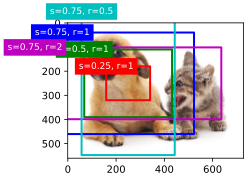

In [6]:

d2l.set_figsize()
bbox_scale = np.array((w, h, w, h))
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale,
            ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2',
             's=0.75, r=0.5'])

### 9.4.2 交并比
### 9.4.3 标注训练集的锚框

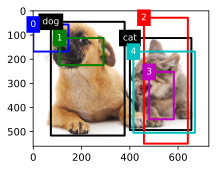

In [7]:
ground_truth = np.array([[0, 0.1, 0.08, 0.52, 0.92],
                         [1, 0.55, 0.2, 0.9, 0.88]])
anchors = np.array([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                    [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                    [0.57, 0.3, 0.92, 0.9]])

fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);

In [8]:
def iou(a, b):
    def intersection(ai, bi):
        x = max(ai[0], bi[0])
        y = max(ai[1], bi[1])
        w = min(ai[2], bi[2]) - x
        h = min(ai[3], bi[3]) - y
        if w < 0 or h < 0:
            return 0
        return w*h

    def union(au, bu, area_intersection):
        area_a = (au[2] - au[0]) * (au[3] - au[1])
        area_b = (bu[2] - bu[0]) * (bu[3] - bu[1])
        area_union = area_a + area_b - area_intersection
        return area_union
    
    if a[0] >= a[2] or a[1] >= a[3] or b[0] >= b[2] or b[1] >= b[3]:
        return 0.0
    
    area_i = intersection(a, b)
    area_u = union(a, b, area_i)
    return float(area_i) / float(area_u + 1e-6)


## anchor: anchor box (1, an, 4)
## label: label (b, gtn, 5)  5 -> (category, x1, y1, x2, y2)
## cls_pred: anchor pred (b, clz+1, an)
# return:
## bbox_offset: anchor offsets (b, an * 4)
## bbox_mask: 
## cls_labels
def MultiBoxTarget(anchor, label, cls_pred, thresh = 0.5):
    # a = anchor
    # b = gt
    def calc_offset(idx, offset, a, b):
        ux = uy = uw = uh = 0
        ax = ay = 0.1
        aw = ah = 0.2
        print('>>>', a, b)
        wa = a[2] - a[0]
        ha = a[3] - a[1]
        wb = b[2] - b[0]
        hb = b[3] - b[1]
        xa = a[0] + wa/2    # centor points
        ya = a[1] + ha/2    # centor points
        xb = b[0] + wb/2    # centor points
        yb = b[1] + hb/2    # centor points
        x1 = ((xb - xa)/wa - ux)/ax
        y1 = ((yb - ya)/ha - uy)/ay
        w1 = (np.log(wb/wa) - uw)/aw
        h1 = (np.log(hb/ha) - uh)/ah
        offset[idx * 4 + 0] = x1
        offset[idx * 4 + 1] = y1
        offset[idx * 4 + 2] = w1
        offset[idx * 4 + 3] = h1
        
    
    assert len(label) == len(cls_pred)
    bbox_offset = []
    bbox_mask = []
    cls_labels = []
    for batch_idx in range(len(label)):
        ious = []   # (label_n, anchor_n)
        offset = [0 for _ in range(len(anchor[0]) * 4)]
        mask = [1 for _ in range(len(anchor[0]) * 4)]
        clabels = [0 for _ in range(len(anchor[0]))]
        for gt in label[batch_idx]:
            ious_label = []
            for anc in anchor[0]:
                ious_label.append(iou(gt[1:5], anc))
            ious.append(ious_label)
        ious = np.array(ious)
        ious2 = np.copy(ious)
        
        for _ in range(len(label[batch_idx])):
            max_iou_idx = np.argmax(ious)
            max_iou_idx = np.unravel_index(max_iou_idx, ious.shape)
            clabels[max_iou_idx[1]] = max_iou_idx[0] + 1  # bg is 0, others + 1
            ious[max_iou_idx[0], :] = -1
            ious[:, max_iou_idx[1]] = -1
            
        for anidx in range(len(clabels)):
            if clabels[anidx] != 0:
                calc_offset(anidx, offset, anchor[0, anidx, :], label[batch_idx, clabels[anidx]-1, 1:5])
                continue
            max_iou_idx = np.argmax(ious2[:,anidx])
            score = ious2[max_iou_idx, anidx]
            if score > thresh:
                clabels[anidx] = max_iou_idx + 1 
                calc_offset(anidx, offset, anchor[0, anidx, :], label[batch_idx, clabels[anidx]-1, 1:5])
            else:
                clabels[anidx] = 0
                mask[anidx * 4 + 0] = 0
                mask[anidx * 4 + 1] = 0
                mask[anidx * 4 + 2] = 0
                mask[anidx * 4 + 3] = 0
                
            
        bbox_offset.append(offset)
        bbox_mask.append(mask)
        cls_labels.append(clabels)
    return np.array(bbox_offset), np.array(bbox_mask), np.array(cls_labels) 

In [9]:
labels = MultiBoxTarget(np.expand_dims(anchors, axis=0),
                        np.expand_dims(ground_truth, axis=0),
                        np.zeros((1, 3, 5)))

>>> [0.15 0.2  0.4  0.4 ] [0.1  0.08 0.52 0.92]
>>> [0.63 0.05 0.88 0.98] [0.55 0.2  0.9  0.88]
>>> [0.57 0.3  0.92 0.9 ] [0.55 0.2  0.9  0.88]


In [10]:
# 第三项表示为锚框标注的类别
labels[2]

array([[0, 1, 2, 0, 2]])

In [11]:
# 第二项为掩码（mask）变量，形状为(批量大小, 锚框个数的四倍)
labels[1]

array([[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1]])

In [12]:
# 第一项是为每个锚框标注的四个偏移量，其中负类锚框的偏移量标注为0。
labels[0]

array([[ 0.00e+00,  0.00e+00,  0.00e+00,  0.00e+00,  1.40e+00,  1.00e+01,
         2.59e+00,  7.18e+00, -1.20e+00,  2.69e-01,  1.68e+00, -1.57e+00,
         0.00e+00,  0.00e+00,  0.00e+00,  0.00e+00, -5.71e-01, -1.00e+00,
        -1.67e-15,  6.26e-01]])

### 9.4.4 输出预测边界框

In [13]:
# 举例
anchors = np.array([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
                    [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88], 
                    [0.9, 0.9, 0.99, 0.99], [0.8, 0.8, 0.99, 0.99]])
offset_preds = np.array([0] * anchors.size)
cls_probs = np.array([[0, 0, 0, 0, 0.9 , 0.9],  # 背景的预测概率
                      [0.9, 0.8, 0.7, 0.1, 0, 0],  # 狗的预测概率
                      [0.1, 0.2, 0.3, 0.9, 0, 0]])  # 猫的预测概率

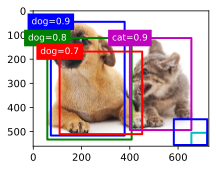

In [14]:
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, anchors * bbox_scale,
            ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

In [15]:
## cls_prob : predicted prob of each anchor (b, clz+1, an)
## anchor : anchor box (1, an * 4)
## threshold : nms threshold
# return: (b, new_an, 6)
##  6-> (category, prob, x1, y1, x2, y2)
##  category = -1 : useless
def NMS(cls_prob, anchor, threshold=0.5):

    output = []
    for bn in range(len(cls_prob)):
        # concat
        c = np.argmax(cls_prob[bn], axis=0)
        c1 = np.expand_dims(c, axis=-1)
        p = np.max(cls_prob[bn], axis=0)
        p1 = np.expand_dims(p, axis=-1)
        La = np.concatenate((c1, p1, anchor[0]), axis=1)
      
        # delete bg (-1)
        id0 = np.argwhere(c==0)
        La[id0, 0] = -1

        deleted = La[La[:, 0]==-1, :]
        La = np.delete(La, id0.reshape(-1), axis=0)
        p = np.delete(p, id0.reshape(-1), axis=0)
        
        # sort
        cls_sort_idx = np.argsort(-p, axis=0)
        Ls = La[cls_sort_idx]
        
        for topidx in range(len(Ls)):
            if topidx >= len(Ls):
                break
            box_top = Ls[topidx, 2:6]
            for othidx in range(topidx + 1, len(Ls)):
                if othidx >= len(Ls):
                    break
         
                box_oth = Ls[othidx, 2:6]
                IoU = iou(box_top, box_oth)
                if IoU > threshold:
                    Ls[othidx, 0] = -1
                    
        deleted = np.concatenate((deleted, Ls[Ls[:, 0]==-1, :]))
        id_1 = np.argwhere(Ls[:,0]==-1)
        Ls = np.delete(Ls, id_1.reshape(-1), axis=0)
        Ls[:,0] -= 1
        output.append(np.concatenate((Ls, deleted)))
    return np.array(output)

In [16]:
output = NMS(
    np.expand_dims(cls_probs, axis=0),
    np.expand_dims(anchors, axis=0), 
    threshold=0.5)
output

array([[[ 0.  ,  0.9 ,  0.1 ,  0.08,  0.52,  0.92],
        [ 1.  ,  0.9 ,  0.55,  0.2 ,  0.9 ,  0.88],
        [-1.  ,  0.9 ,  0.9 ,  0.9 ,  0.99,  0.99],
        [-1.  ,  0.9 ,  0.8 ,  0.8 ,  0.99,  0.99],
        [-1.  ,  0.8 ,  0.08,  0.2 ,  0.56,  0.95],
        [-1.  ,  0.7 ,  0.15,  0.3 ,  0.62,  0.91]]])

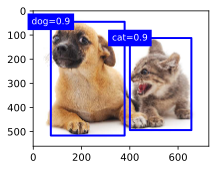

In [17]:
fig = d2l.plt.imshow(img)
for i in output[0]:
    if i[0] == -1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [np.array(i[2:]) * bbox_scale], label)